In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Parameters

In [2]:
img_height, img_width = 224, 224
batch_size = 16
epochs = 10
learning_rate = 0.001
sequence_length = 10  # Number of frames to consider in each sequence
dataset_path = '/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset'

# Device configuration

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(device)

cuda


# transformations

In [5]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# extract frames from a video

In [6]:
def extract_frames(video_path, sequence_length, interval=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while len(frames) < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            frame = cv2.resize(frame, (img_height, img_width))
            frames.append(frame)
        frame_count += 1
    cap.release()

    # Handle cases where there are fewer frames than sequence_length
    if len(frames) < sequence_length:
        while len(frames) < sequence_length:
            frames.append(frames[-1] if frames else cv2.resize(np.zeros((img_height, img_width, 3), dtype=np.uint8), (img_height, img_width)))
    else:
        frames = frames[:sequence_length]

    return frames

# Dataset

In [7]:
class VideoDataset(Dataset):
    def __init__(self, video_files, labels, transform=None, sequence_length=10):
        self.video_files = video_files
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        frames = extract_frames(self.video_files[idx], self.sequence_length)
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        label = self.labels[idx]
        return torch.stack(frames), label

# Load dataset

In [8]:
def load_dataset(dataset_path):
    video_files = []
    labels = []
    classes = os.listdir(dataset_path)
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        videos = os.listdir(class_path)
        for video_name in videos:
            video_path = os.path.join(class_path, video_name)
            video_files.append(video_path)
            labels.append(label)
    return video_files, labels

# Split

In [9]:
video_files, labels = load_dataset(dataset_path)
train_videos, temp_videos, train_labels, temp_labels = train_test_split(video_files, labels, test_size=0.3, random_state=42)
val_videos, test_videos, val_labels, test_labels = train_test_split(temp_videos, temp_labels, test_size=0.5, random_state=42)

In [10]:
train_dataset = VideoDataset(train_videos, train_labels, transform=data_transforms, sequence_length=sequence_length)
val_dataset = VideoDataset(val_videos, val_labels, transform=data_transforms, sequence_length=sequence_length)
test_dataset = VideoDataset(test_videos, test_labels, transform=data_transforms, sequence_length=sequence_length)

# DataLoader

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Model

In [12]:
class MobileNetLSTM(nn.Module):
    def __init__(self, hidden_dim, num_classes, num_layers=1):
        super(MobileNetLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Load pre-trained MobileNetV2
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier = nn.Identity()  # Remove the last fully connected layer

        # LSTM
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()

        # Reshape to (batch_size * seq_length, c, h, w) to feed each frame into MobileNet
        x = x.view(batch_size * seq_length, c, h, w)
        with torch.no_grad():
            x = self.mobilenet(x)
        
        # Reshape back to (batch_size, seq_length, 1280) to feed into LSTM
        x = x.view(batch_size, seq_length, -1)

        # LSTM
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        x, _ = self.lstm(x, (h0, c0))

        # Classification
        x = self.fc(x[:, -1, :])  # Use the output of the last LSTM cell

        return x

In [13]:
hidden_dim = 512
num_classes = 2
model = MobileNetLSTM(hidden_dim, num_classes).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 86.6MB/s]


# loss function and optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training 

In [15]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.item())

        print(f'Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [16]:
model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)

[h264 @ 0x5a4937a64fc0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a4937a64fc0] error while decoding MB 98 31


Epoch 0/10, Loss: 0.3663, Acc: 0.8271, Val Loss: 0.2332, Val Acc: 0.9200


[h264 @ 0x5a4939e83980] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a4939e83980] error while decoding MB 98 31


Epoch 1/10, Loss: 0.3202, Acc: 0.8607, Val Loss: 0.2211, Val Acc: 0.9267


[h264 @ 0x5a4937e8bb40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a4937e8bb40] error while decoding MB 98 31


Epoch 2/10, Loss: 0.3051, Acc: 0.8743, Val Loss: 0.2927, Val Acc: 0.8533


[h264 @ 0x5a493a583e40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a493a583e40] error while decoding MB 98 31


Epoch 3/10, Loss: 0.2438, Acc: 0.9050, Val Loss: 0.1874, Val Acc: 0.9400


[h264 @ 0x5a4939d8b2c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a4939d8b2c0] error while decoding MB 98 31


Epoch 4/10, Loss: 0.2045, Acc: 0.9193, Val Loss: 0.1930, Val Acc: 0.9167


[h264 @ 0x5a4937e83a00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a4937e83a00] error while decoding MB 98 31


Epoch 5/10, Loss: 0.2138, Acc: 0.9093, Val Loss: 0.1618, Val Acc: 0.9400


[h264 @ 0x5a493a71d7c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a493a71d7c0] error while decoding MB 98 31


Epoch 6/10, Loss: 0.2461, Acc: 0.8950, Val Loss: 0.1933, Val Acc: 0.9167


[h264 @ 0x5a4939c689c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a4939c689c0] error while decoding MB 98 31


Epoch 7/10, Loss: 0.1801, Acc: 0.9250, Val Loss: 0.1389, Val Acc: 0.9467


[h264 @ 0x5a4939e3d180] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a4939e3d180] error while decoding MB 98 31


Epoch 8/10, Loss: 0.1583, Acc: 0.9357, Val Loss: 0.1094, Val Acc: 0.9633


[h264 @ 0x5a4939f2fa40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a4939f2fa40] error while decoding MB 98 31


Epoch 9/10, Loss: 0.1485, Acc: 0.9450, Val Loss: 0.1217, Val Acc: 0.9633


# Evaluate 

In [17]:
model.eval()
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9400


# Plotting

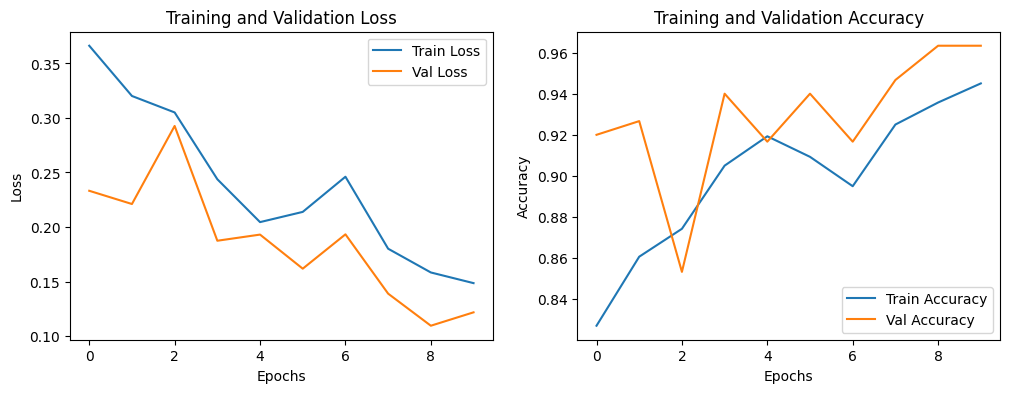

In [18]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, label='Train Accuracy')
plt.plot(epochs_range, val_acc_history, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()